In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import floor
from z3 import *

In [2]:
taskset  = pd.read_csv('example.csv')

In [3]:
taskset

,Task,Computation,Period,Deadline
0,1,2,6,6
1,2,2,9,9
2,3,2,12,8
3,4,4,18,10


In [4]:
hyper_period = np.lcm.reduce(taskset.Period.values)
hyper_period

36

In [5]:
min_frame_size = np.max(taskset.Computation.values)
max_frame_size = np.min(taskset.Period.values)
print(min_frame_size, max_frame_size)

4 6


In [6]:
possible_frame_sizes = np.arange(min_frame_size, max_frame_size+1,1)
possible_frame_sizes

array([4, 5, 6], dtype=int64)

In [7]:
def get_valid_frame_sizes(possible_frame_sizes, hyper_period):
    possible_frame_sizes = np.array(possible_frame_sizes)
    
    is_multiple = np.mod(hyper_period, possible_frame_sizes) == 0

    return np.array(possible_frame_sizes[is_multiple])
    

In [8]:
valid_frame_sizes = get_valid_frame_sizes(possible_frame_sizes, hyper_period)
valid_frame_sizes

array([4, 6], dtype=int64)

In [9]:
final_frame_sizes = []
for frame_size in valid_frame_sizes:
    count = 0
    for _, row in taskset.iterrows():
        # print(row)
        condition = 2*frame_size - np.gcd(row.Period, frame_size)<= row.Deadline
        if condition:
            count+=1
        if count == len(taskset):
            final_frame_sizes.append(frame_size)
print(np.array(final_frame_sizes))

[4 6]


In [10]:
frame_size = final_frame_sizes[0]
print(hyper_period,frame_size)

36 4


In [11]:
def get_taskset_dict_list(taskset_df):
    taskset_list = []
    for ind,row in taskset_df.iterrows():
        dict = {"Task":int(row['Task']), "Computation":int(row['Computation']), "Period":int(row['Period']), "Deadline":int(row['Deadline'])}
        taskset_list.append(dict)
    return taskset_list

task_set = get_taskset_dict_list(taskset)
task_set

[{'Task': 1, 'Computation': 2, 'Period': 6, 'Deadline': 6},
 {'Task': 2, 'Computation': 2, 'Period': 9, 'Deadline': 9},
 {'Task': 3, 'Computation': 2, 'Period': 12, 'Deadline': 8},
 {'Task': 4, 'Computation': 4, 'Period': 18, 'Deadline': 10}]

In [32]:
from z3 import Solver, Int, sat



# Sort the task set by periods
task_set_sorted = sorted(task_set, key=lambda x: x['Deadline'])

# Find the hyper period
hyper_period = hyper_period#task_set_sorted[-1]['Period']

# Define the start times of the tasks as integer variables
start_times = [Int(f"start_time_{task['Task']}") for task in task_set_sorted]

# Create a solver
smt = Solver()




In [33]:
task_set

[{'Task': 1, 'Computation': 2, 'Period': 6, 'Deadline': 6},
 {'Task': 2, 'Computation': 2, 'Period': 9, 'Deadline': 9},
 {'Task': 3, 'Computation': 2, 'Period': 12, 'Deadline': 8},
 {'Task': 4, 'Computation': 4, 'Period': 18, 'Deadline': 10}]

In [34]:
release_instances_optim = []
for task in task_set_sorted:
    task_list = []
    for nn in range(int(floor(hyper_period / task["Period"]))):
        # print(nn)
        task_list.append(Int("Task"+str(task['Task']) + "_" + "inst_" + str(nn)))
    release_instances_optim.append(task_list)
    

In [35]:
(release_instances_optim)

[[Task1_inst_0,
  Task1_inst_1,
  Task1_inst_2,
  Task1_inst_3,
  Task1_inst_4,
  Task1_inst_5],
 [Task3_inst_0, Task3_inst_1, Task3_inst_2],
 [Task2_inst_0, Task2_inst_1, Task2_inst_2, Task2_inst_3],
 [Task4_inst_0, Task4_inst_1]]

In [36]:
release_instances = []
for item in task_set:
    # print(task_set)
    computation_t = item["Computation"]
    num_instances = int(floor(hyper_period/item["Period"]))
    prev_period = 0
    deadline = item['Deadline']
    # print(item)
    instances = []
    prev_deadline = deadline
    for i in range(num_instances):
        # print(prev_period, prev_deadline)
        instances.append({"Period": prev_period, "Deadline":prev_deadline, "Computation":computation_t})
        prev_period +=item["Period"]
        prev_deadline = prev_period + deadline
    release_instances.append(instances)


In [37]:
release_instances

[[{'Period': 0, 'Deadline': 6, 'Computation': 2},
  {'Period': 6, 'Deadline': 12, 'Computation': 2},
  {'Period': 12, 'Deadline': 18, 'Computation': 2},
  {'Period': 18, 'Deadline': 24, 'Computation': 2},
  {'Period': 24, 'Deadline': 30, 'Computation': 2},
  {'Period': 30, 'Deadline': 36, 'Computation': 2}],
 [{'Period': 0, 'Deadline': 9, 'Computation': 2},
  {'Period': 9, 'Deadline': 18, 'Computation': 2},
  {'Period': 18, 'Deadline': 27, 'Computation': 2},
  {'Period': 27, 'Deadline': 36, 'Computation': 2}],
 [{'Period': 0, 'Deadline': 8, 'Computation': 2},
  {'Period': 12, 'Deadline': 20, 'Computation': 2},
  {'Period': 24, 'Deadline': 32, 'Computation': 2}],
 [{'Period': 0, 'Deadline': 10, 'Computation': 4},
  {'Period': 18, 'Deadline': 28, 'Computation': 4}]]

In [38]:
# Add constraints for each task
for i, task in enumerate(task_set_sorted):
    prev_st = None
    for var, optim_var in zip(release_instances[i], release_instances_optim[i]):
        
        start_time = optim_var
        computation_time = task['Computation']
        period = var['Period']
        deadline = var['Deadline']

        # Start time must be non-negative
        smt.add(start_time >= 0)
        for ii in release_instances_optim:
            
            for jj in ii:
                # print(jj,start_time)
                if not(jj==start_time):
                    smt.add(Or(
                        start_time + computation_time <= jj,
                        start_time >= jj +2 
                    ))
                   
                
        
        smt.add(And(start_time>=period),(start_time + computation_time <=  deadline))
        
        
        prev_st = start_time 

# Check if there is a solution
if smt.check() == sat:
    model = smt.model()
    ploting_list = []
    for i, task in enumerate(task_set_sorted):
        schedule = []
        for var, optim_var in zip(release_instances[i], release_instances_optim[i]):
            # print(var)
            schedule.append(( model.evaluate(optim_var).as_long(), model.evaluate(optim_var + task['Computation']).as_long(),var["Computation"]))
            schedule.sort(key=lambda x: x[1])  # Sort the schedule by start time
        ploting_list.append(schedule)
        # Print the schedule
        for start_time, end_time, computation in schedule:
            print(f"Task: {task}, Start: {start_time}, End: {end_time}, Computation_time:{computation}")
else:
    print("No feasible schedule exists.")


Task: {'Task': 1, 'Computation': 2, 'Period': 6, 'Deadline': 6}, Start: 0, End: 2, Computation_time:2
Task: {'Task': 1, 'Computation': 2, 'Period': 6, 'Deadline': 6}, Start: 10, End: 12, Computation_time:2
Task: {'Task': 1, 'Computation': 2, 'Period': 6, 'Deadline': 6}, Start: 12, End: 14, Computation_time:2
Task: {'Task': 1, 'Computation': 2, 'Period': 6, 'Deadline': 6}, Start: 18, End: 20, Computation_time:2
Task: {'Task': 1, 'Computation': 2, 'Period': 6, 'Deadline': 6}, Start: 28, End: 30, Computation_time:2
Task: {'Task': 1, 'Computation': 2, 'Period': 6, 'Deadline': 6}, Start: 32, End: 34, Computation_time:2
Task: {'Task': 3, 'Computation': 2, 'Period': 12, 'Deadline': 8}, Start: 2, End: 4, Computation_time:2
Task: {'Task': 3, 'Computation': 2, 'Period': 12, 'Deadline': 8}, Start: 14, End: 16, Computation_time:2
Task: {'Task': 3, 'Computation': 2, 'Period': 12, 'Deadline': 8}, Start: 20, End: 22, Computation_time:2
Task: {'Task': 2, 'Computation': 2, 'Period': 9, 'Deadline': 9}, 

In [39]:
ploting_list

[[(0, 2, 2), (10, 12, 2), (12, 14, 2), (18, 20, 2), (28, 30, 2), (32, 34, 2)],
 [(2, 4, 2), (14, 16, 2), (20, 22, 2)],
 [(4, 6, 2), (16, 18, 2), (30, 32, 2)],
 [(6, 10, 4), (24, 28, 4)]]

C:\Users\ShahabKhan\AppData\Local\Temp\ipykernel_6844\844846266.py:22: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='#666666', linestyle='-')
C:\Users\ShahabKhan\AppData\Local\Temp\ipykernel_6844\844846266.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)



Schedule plotted for %s hyper-periods



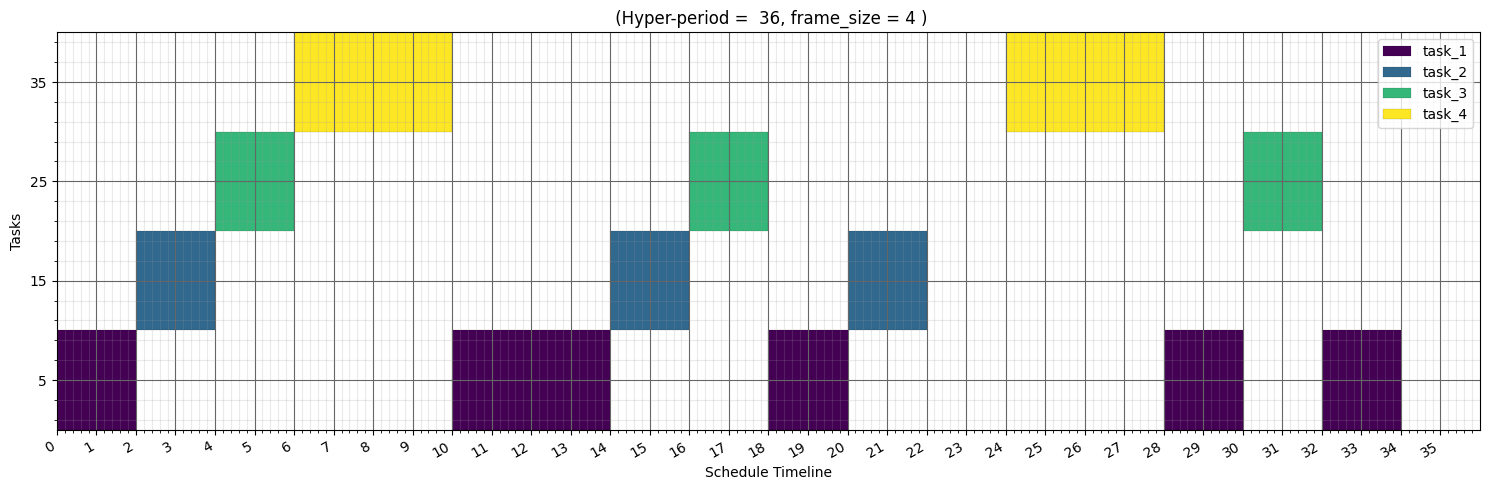

In [40]:
figsize = (15, 5) 
fig, axis = plt.subplots(figsize=figsize)
plt.subplots_adjust(left=0.05, bottom=0.10, right=0.97, top=0.96)


plt.title(f" (Hyper-period =  {(hyper_period)}, frame_size = {frame_size} )")

# Setting Y-axis limits
axis.set_ylim(0, len(ploting_list) * 10)
# Setting X-axis limits
axis.set_xlim(0, hyper_period )
# Setting labels for x-axis and y-axis
axis.set_xlabel('Schedule Timeline')
axis.set_ylabel('Tasks')
# axis.set_xticks(range(0, periods*Sum([t.getStartPIT()+t.execution for t in taskSet]), 5000))
axis.set_xticks(range(0, hyper_period , 1))
# Setting ticks on y-axis
axis.set_yticks(range(5, len(ploting_list) * 10 + 5, 10))
# Labelling tickes of y-axis

# Show the major grid lines with dark grey lines
plt.grid(b=True, which='major', color='#666666', linestyle='-')
# Show the minor grid lines with very faint and almost transparent grey lines
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
# Color map
cmap = plt.cm.get_cmap('viridis', len(ploting_list))
print("\nSchedule plotted for %s hyper-periods\n" )
for ind,i in enumerate(ploting_list):
    taskExecutionBars = []    
    for jj in i:
        start = jj[0] 
        end = jj[1]
        computation = jj[2]
        taskExecutionBars.append((start, computation))
    task_label = f"task_{ind + 1}"
    axis.broken_barh(taskExecutionBars, (ind * 10, 10), label=task_label, facecolors=cmap(ind), edgecolor='k',
                        linestyle='dotted', linewidth=0.2)

axis.legend()
fig.autofmt_xdate()
fig.tight_layout()
fig.savefig('figures/figure2.jpg', format='jpg', dpi=500, transparent=False)  # Save as PNG file with 300 DPI resolution
plt.show()